ここに簡単な説明を書く

ReadMeにも書く

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 事前準備

インポート

In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
import os
from tqdm.notebook import tqdm

from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils

各種設定

In [3]:
# シード値設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 潜在変数の領域
z_dim = 100

# バッチ数
batch_size = 64

# 画像サイズ
img_size = 64

# エポック数
num_epochs = 250

使用デバイス確認

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


リポジトリクローン、訓練データ展開

In [5]:
!git clone https://github.com/MamedenQ/VolleyballDesign
!unzip VolleyballDesign/data.zip

Cloning into 'VolleyballDesign'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 8 (delta 0), reused 3 (delta 0), pack-reused 5
Unpacking objects: 100% (8/8), done.
Archive:  VolleyballDesign/data.zip
   creating: data/
   creating: data/molten/
  inflating: data/molten/30316.jpg   
  inflating: data/molten/20214.jpg   
  inflating: data/molten/30121.jpg   
  inflating: data/molten/30303.jpg   
  inflating: data/molten/20142.jpg   
  inflating: data/molten/10223.jpg   
  inflating: data/molten/10142.jpg   
  inflating: data/molten/30140.jpg   
  inflating: data/molten/30311.jpg   
  inflating: data/molten/10087.jpg   
  inflating: data/molten/10040.jpg   
  inflating: data/molten/30024.jpg   
  inflating: data/molten/30282.jpg   
  inflating: data/molten/20001.jpg   
  inflating: data/molten/20200.jpg   
  inflating: data/molten/20084.jpg   
  inflating: data/molten/10124.jpg   
  inflating: data/molten/10273.jpg   
  inflating: data/mo

# Generatorの作成

定義

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, img_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, img_size * 8,
                               kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(img_size * 8, img_size * 4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(img_size * 4, img_size * 2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(img_size * 2, img_size,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(img_size, 3, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

生成、動作確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


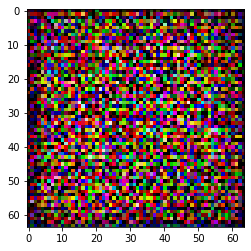

In [7]:
generator = Generator(z_dim=z_dim, img_size=img_size)

# randnは標準正規分布(平均0, 分散1の正規分布)に従う乱数を取り出す
input_z = torch.randn(1, z_dim, 1, 1)

# 偽画像を出力
fake_imgs = generator(input_z)

# 偽画像表示
plt.imshow(np.transpose(fake_imgs[0].detach().numpy(), (1, 2, 0)))
plt.show()

# Discriminatorの作成

定義

In [8]:
class Discriminator(nn.Module):
    def __init__(self, img_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, img_size, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(img_size, img_size*2, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(img_size*2, img_size*4, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(img_size*4, img_size*8, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.LeakyReLU(0.2, inplace=True))

        self.last = nn.Sequential(
            nn.Conv2d(img_size*8, 1, kernel_size=4, stride=1,
                      padding=0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

生成、動作確認

In [9]:
discriminator = Discriminator(img_size=img_size)

# 偽画像を生成
input_z = torch.randn(1, z_dim, 1, 1)
fake_imgs = generator(input_z)

# 偽画像をDiscriminatorに入力
d_out = discriminator(fake_imgs)

# 判定結果発表
print(d_out)

tensor([[[[0.5585]]]], grad_fn=<SigmoidBackward0>)


# DataLoaderの作成

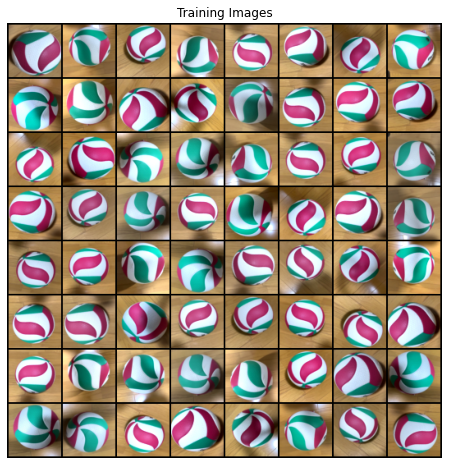

In [10]:
train_dataset = datasets.ImageFolder(root="data",
    transform=transforms.Compose([
        transforms.Resize((img_size, img_size)),
        # transforms.CenterCrop(img_size),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=(1, 1.3), contrast=(1, 1.2), saturation=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(dataloader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),
        (1, 2, 0)))

# 学習

ネットワーク初期化

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (last): Sequential(
    (0): Conv2d(5

事前設定

In [12]:
# 最適化手法の設定
g_lr, d_lr = 0.0002, 0.0002
beta1, beta2 = 0.5, 0.999
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])

# 誤差関数を定義
criterion = nn.BCELoss()

# ネットワークをGPUへ
generator.to(device)
discriminator.to(device)

# 訓練モード設定
generator.train()
discriminator.train()

# ネットワークがある程度固定であれば、高速化させる
torch.backends.cudnn.benchmark = True

# 損失のリスト初期化
g_loss_all = []
d_loss_all = []

途中状態から再開する場合

In [50]:
first_train = False

if first_train:
    # 初回学習時
    last_epoch = 0
else:
    # 途中再開
    checkpoint = torch.load("/content/drive/MyDrive/Colaboratory/gan/last_model_state_1000.pth")

    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

    g_optimizer.load_state_dict(checkpoint["g_optimizer_state_dict"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer_state_dict"])

    last_epoch = checkpoint["epoch"]

    g_loss_all = checkpoint["g_loss"]
    d_loss_all = checkpoint["d_loss"]

    # ネットワークをGPUへ
    generator.to(device)
    discriminator.to(device)

    # 訓練モード設定
    generator.train()
    discriminator.train()

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (last): Sequential(
    (0): Conv2d(5

学習処理

  0%|          | 0/250 [00:00<?, ?it/s]

epoch 1 || d_loss:0.0129 g_loss:6.6716 timer: 19.4779 sec.
epoch 2 || d_loss:0.0213 g_loss:6.9047 timer: 19.3155 sec.
epoch 3 || d_loss:0.0112 g_loss:6.8349 timer: 19.4596 sec.
epoch 4 || d_loss:0.0074 g_loss:7.0133 timer: 19.3702 sec.
epoch 5 || d_loss:0.0075 g_loss:7.0548 timer: 19.4326 sec.
epoch 6 || d_loss:0.0091 g_loss:6.9958 timer: 19.4131 sec.
epoch 7 || d_loss:0.0095 g_loss:6.9724 timer: 19.5709 sec.
epoch 8 || d_loss:0.0117 g_loss:6.9791 timer: 19.6087 sec.
epoch 9 || d_loss:0.0241 g_loss:6.9942 timer: 19.4516 sec.
epoch 10 || d_loss:0.0435 g_loss:7.2814 timer: 19.4818 sec.
epoch 11 || d_loss:0.0112 g_loss:6.7515 timer: 19.4995 sec.
epoch 12 || d_loss:0.0331 g_loss:7.3875 timer: 19.4789 sec.
epoch 13 || d_loss:2.1685 g_loss:3.9119 timer: 19.6227 sec.
epoch 14 || d_loss:0.5738 g_loss:3.6195 timer: 19.4903 sec.
epoch 15 || d_loss:0.2607 g_loss:3.3675 timer: 19.5704 sec.
epoch 16 || d_loss:0.1696 g_loss:3.8319 timer: 19.5690 sec.
epoch 17 || d_loss:0.1508 g_loss:4.2016 timer: 19

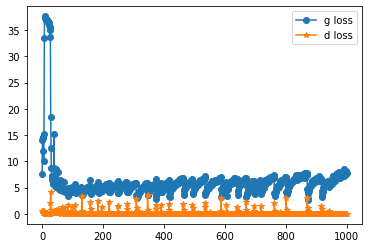

In [51]:
t_start = time.time()

for epoch in tqdm(range(num_epochs)):
    t_epoch_start = time.time()

    # epoch内の損失を溜め込むリスト
    epoch_g_loss = []
    epoch_d_loss = []

    for imgs in dataloader:
        ##################
        # Discriminator学習
        ##################

        # GPUが使えるならGPUにデータを送る
        imgs = imgs[0].to(device)

        # 正解ラベルと偽ラベルを作成
        # epochの最後のイテレーションはミニバッチの数が少なくなる
        cur_batch_size = imgs.size(0)
        label_real = torch.full((cur_batch_size,), 1).to(device)
        label_fake = torch.full((cur_batch_size,), 0).to(device)

        # 真の画像を判定
        d_out_real = discriminator(imgs)

        # 偽の画像を生成して判定
        input_z = torch.randn(cur_batch_size, z_dim).to(device)
        input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
        fake_imgs = generator(input_z)
        d_out_fake = discriminator(fake_imgs)

        # 誤差を計算
        label_real = label_real.type_as(d_out_real.view(-1))
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        label_fake = label_fake.type_as(d_out_fake.view(-1))
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # バックプロパゲーション
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()

        ##################
        # Generator学習
        ##################

        # 偽の画像を生成して判定
        input_z = torch.randn(cur_batch_size, z_dim).to(device)
        input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
        fake_imgs = generator(input_z)
        d_out_fake = discriminator(fake_imgs)

        last_d_out_fake = d_out_fake

        # 誤差を計算
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # バックプロパゲーション
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        epoch_d_loss.append(d_loss.item())
        epoch_g_loss.append(g_loss.item())

    g_losses_mean = np.mean(epoch_g_loss)
    d_losses_mean = np.mean(epoch_d_loss)
    g_loss_all.append(g_losses_mean)
    d_loss_all.append(d_losses_mean)

    tqdm.write('epoch {} || d_loss:{:.4f} g_loss:{:.4f} timer: {:.4f} sec.'.format(
        epoch + 1,
        d_losses_mean,
        g_losses_mean,
        time.time() - t_epoch_start))

# 損失をグラフ化
fig, ax = plt.subplots(1, 1)
ax.plot(g_loss_all, label="g loss", marker="o")
ax.plot(d_loss_all, label="d loss", marker="*")
ax.legend()

print("finish time:{:.4f} sec.".format(time.time() - t_start))

途中状態保存

In [52]:
# 途中保存の場合にこのセルを実行する
torch.save({
    "label": "basic",
    "epoch": last_epoch + num_epochs,
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "g_optimizer_state_dict": g_optimizer.state_dict(),
    "d_optimizer_state_dict": d_optimizer.state_dict(),
    "g_loss": g_loss_all,
    "d_loss": d_loss_all,
}, "/content/drive/MyDrive/Colaboratory/gan/last_model_state_{}.pth".format(last_epoch + num_epochs))

モデルの保存

In [129]:
torch.save(generator.state_dict(), "/content/drive/MyDrive/Colaboratory/gan/last_generate_model_state_{}.pt".format(last_epoch + num_epochs))

# 画像生成

モデル読み込み

In [54]:
# generator.load_state_dict(torch.load("model/generate.pt"))

画像生成

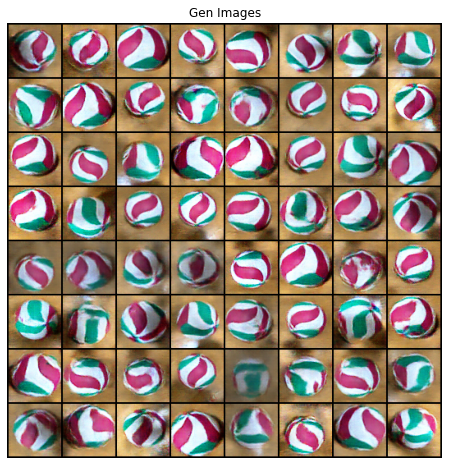

In [208]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Gen Images")

fixed_z = torch.randn(64, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

generator.eval()
fake_img = generator(fixed_z.to(device))

plt.imshow(
    np.transpose(
        vutils.make_grid(fake_img, padding=2, normalize=True).cpu(),
        (1, 2, 0)))